# CNN + GlobalAvgPool
With threshold set by EM/GMM.

Slight disconnect: transcripts are filtered by length, but RCI threshold is computed with the RCI from all genes.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-04 12:57:52.044031
Python 3.10.0
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=4000   

2023-02-04 12:57:55.482485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

/Users/jasonmiller/WVU/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE =   'CNRCI_noncoding_train_counts.K4.gc42.csv'
PICKLE_FILE =   'CNRCI_noncoding_A548_K4_200_4000.pkl'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

CELL_LINE = 0
print('Cell line for today',CELL_LINE,all_cell_lines[CELL_LINE])
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Cell line for today 0 A549
Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[CELL_LINE]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        cache = DATA_DIR+PICKLE_FILE # TO DO: parameterize
        if isfile(cache):
            with open(cache,'rb') as fin:
                alldata = pickle.load(fin)
                labels=alldata[0]
                allids=alldata[1]
                allseq=alldata[2]
                return labels,allids,allseq

        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        with open(cache,'wb') as fout:
            alldata = [labels,allids,allseq]
            pickle.dump(alldata,fout)
        return labels,allids,allseq

In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
#print('Num labels:',len(labels))
#print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
#print('Num sequences:',len(allseq))
#print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-02-04 12:58:04.597408
Load RCI values...
Number of RCI values loaded 1447
Num RCI: 1447
Example RCI: [('ENSG00000116652', -1.848), ('ENSG00000117242', -0.25673), ('ENSG00000125462', 0.13734)]
Load genes...
2023-02-04 12:58:04.616192
Load sequence...
2023-02-04 12:58:05.536026
Num IDs: 8474
Example IDs: [('ENSG00000237491', 'ENST00000665867.1'), ('ENSG00000237491', 'ENST00000586928.5'), ('ENSG00000237491', 'ENST00000655384.1'), ('ENSG00000228794', 'ENST00000688008.2')]
Count 6584 ones out of 8474 labels.


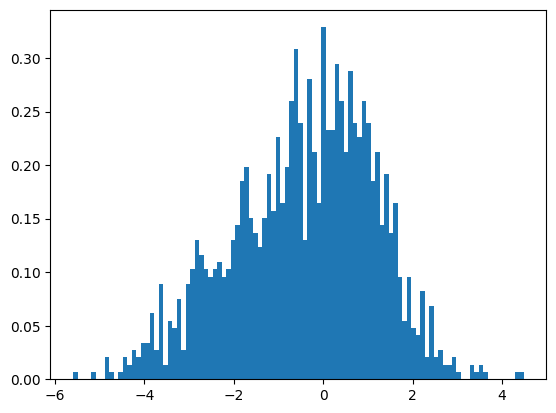

Cell Line 0 A549
Number of RCI values 1447
Range of RCI values -5.59991 4.49338
GaussianMixture(covariance_type='spherical', n_components=2)
AIC 5401.404203519043 BIC 5427.790442152201 score -1.8629592963092754
Gaussian 0 mean= [-1.90685899] wgt= 0.3778852178594566 cov= 1.4530283777459643
Gaussian 1 mean= [0.4586882] wgt= 0.6221147821405434 cov= 1.0743929606725646
RCI threshold [-0.43521711]


In [8]:
def show_plot(X,cell_line,num_bins=100):
    plt.hist(X, bins=num_bins, density=True)
    plt.show()
    print('Cell Line',cell_line,all_cell_lines[cell_line])
    print('Number of RCI values',len(X))
    print('Range of RCI values', min(X), max(X))

def show_gmm(model,X):
    print(model)
    print('AIC',model.aic(X),'BIC',model.bic(X),'score',model.score(X))
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 'cov=',model.covariances_[i])

def get_threshold(cell_line):
    values = list(gene_to_rci.values())
    show_plot(values,cell_line)
    values = np.array(values)
    values = values.reshape(-1, 1)
    NUM_GAUSSIANS = 2
    model = GaussianMixture(n_components=NUM_GAUSSIANS, 
                            verbose=0, covariance_type='spherical') # default='full'
    model.fit(values)
    show_gmm(model,values)
    # weighted average is sum of pairwise products
    # probably a faster way to do this with numpy
    threshold=model.means_[0]*model.weights_[0]+model.means_[1]*model.weights_[1]
    return threshold

RCI_THRESHOLD = get_threshold(CELL_LINE)
print('RCI threshold',RCI_THRESHOLD)

## Model

In [9]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [10]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-04 12:58:06.261118


2023-02-04 12:58:06.298287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 3982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 496, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 31744)             0         
                                                                 
 dense (Dense)               (None, 16)                507920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                

## Training

In [11]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )

            print(datetime.now())

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Train sizes',X_train.shape,y_train.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))

            print("Compute valiation accuracy")
            print(datetime.now())
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))
            yhat_pred=model.predict(X_valid, verbose=0) 
            
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Score threshold',self.threshold)
            print('Prediction set ones/size',
                  np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            count_ones= len(y_valid[y_valid==1])
            count_zeros= len(y_valid[y_valid==0])
            guess = max(count_ones,count_zeros) / len(y_valid)
            plt.plot(prc_X, prc_Y, marker='.')
            plt.plot([0, 1], [guess,guess], linestyle='--')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.show()
            # ROC
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
            plt.plot(fpr, tpr, marker='.')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            train_genes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-04 12:58:06.787594
2023-02-04 12:58:06.788377
splitting
Fold 1
Training example
[ 14  53 211 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-02-04 12:58:09.635713
Epoch 1/3
214/214 [==============================] - 31s 137ms/step - loss: 0.5127 - accuracy: 0.7882 - val_loss: 0.5695 - val_accuracy: 0.7213
Epoch 2/3
214/214 [==============================] - 27s 125ms/step - loss: 0.4662 - accuracy: 0.8089 - val_loss: 0.5732 - val_accuracy: 0.7311
Epoch 3/3
214/214 [==============================] - 27s 128ms/step - loss: 0.4112 - accuracy: 0.8340 - val_loss: 0.5836 - val_accuracy: 0.7170
2023-02-04 12:59:35.234340


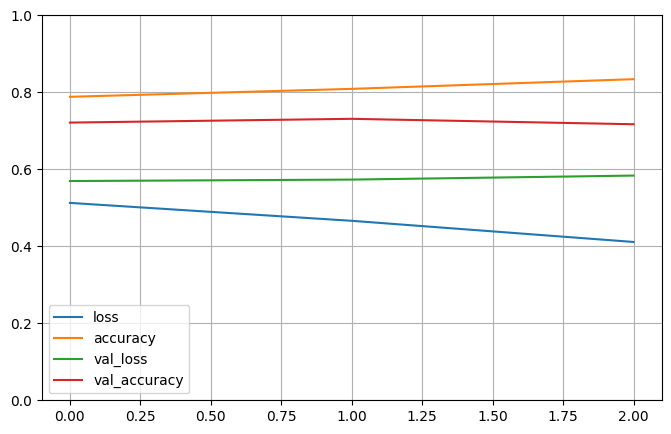

Train sizes (6838, 3997) (6838, 1)
Train set ones/size 5415 / 6838
Compute valiation accuracy
2023-02-04 12:59:35.500367
Valid sizes (1636, 3997) (1636, 1)
Valid set ones/size 1169 / 1636
Range of scores: 0.002449515 to 0.98993176
Score threshold 0.5
Prediction set ones/size 1424 / 1636


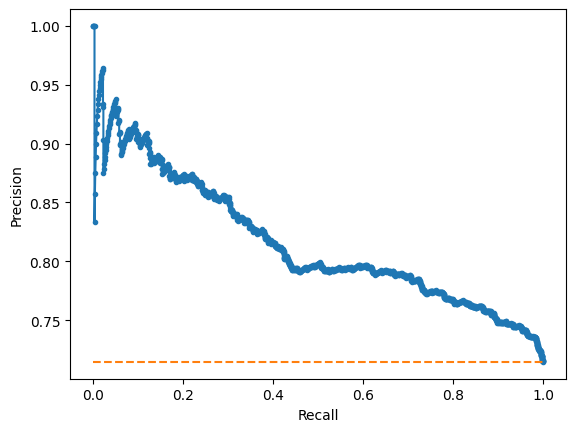

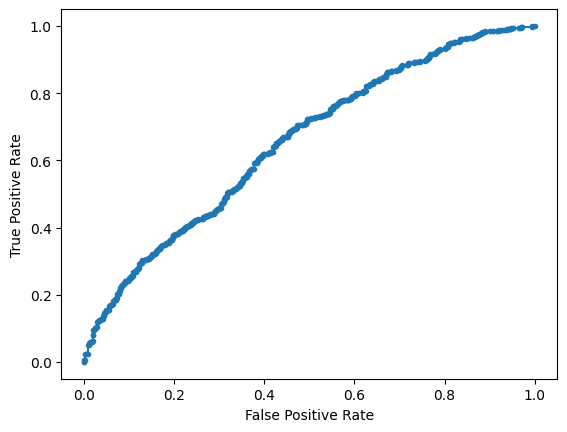

Accuracy: 71.70% Precision: 74.79% Recall: 91.10%
F1: 82.14% AUPRC: 81.56% AUROC: 65.36%
2023-02-04 12:59:37.309534
Fold 2
Training example
[211  74  38 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-02-04 12:59:41.364615
Epoch 1/3
213/213 [==============================] - 28s 129ms/step - loss: 0.5222 - accuracy: 0.7758 - val_loss: 0.5651 - val_accuracy: 0.7601
Epoch 2/3
213/213 [==============================] - 28s 130ms/step - loss: 0.4627 - accuracy: 0.8038 - val_loss: 0.5761 - val_accuracy: 0.7548
Epoch 3/3
213/213 [==============================] - 27s 128ms/step - loss: 0.4104 - accuracy: 0.8272 - val_loss: 0.6068 - val_accuracy: 0.7542
2023-02-04 13:01:04.700346


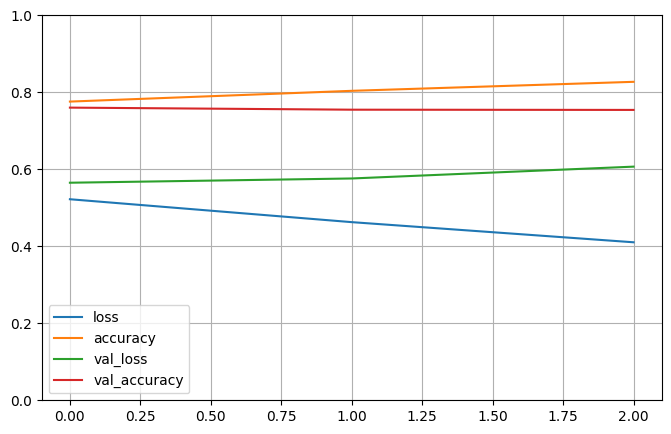

Train sizes (6798, 3997) (6798, 1)
Train set ones/size 5309 / 6798
Compute valiation accuracy
2023-02-04 13:01:04.914626
Valid sizes (1676, 3997) (1676, 1)
Valid set ones/size 1275 / 1676
Range of scores: 0.0400535 to 0.9977081
Score threshold 0.5
Prediction set ones/size 1557 / 1676


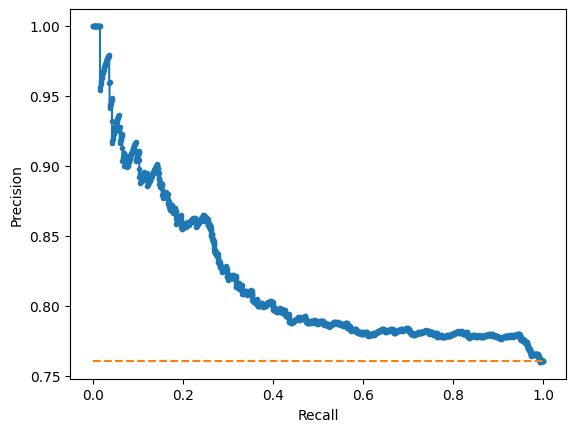

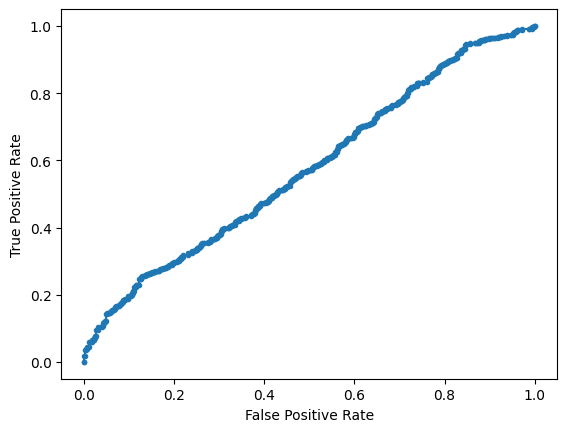

Accuracy: 75.42% Precision: 77.71% Recall: 94.90%
F1: 85.45% AUPRC: 81.75% AUROC: 57.60%
2023-02-04 13:01:06.681229
Fold 3
Training example
[211  74  38 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-02-04 13:01:10.714139
Epoch 1/3
218/218 [==============================] - 28s 123ms/step - loss: 0.5139 - accuracy: 0.7825 - val_loss: 0.5866 - val_accuracy: 0.7084
Epoch 2/3
218/218 [==============================] - 29s 132ms/step - loss: 0.4288 - accuracy: 0.8230 - val_loss: 0.6201 - val_accuracy: 0.7531
Epoch 3/3
218/218 [==============================] - 28s 127ms/step - loss: 0.3798 - accuracy: 0.8433 - val_loss: 0.6495 - val_accuracy: 0.7281
2023-02-04 13:02:35.226661


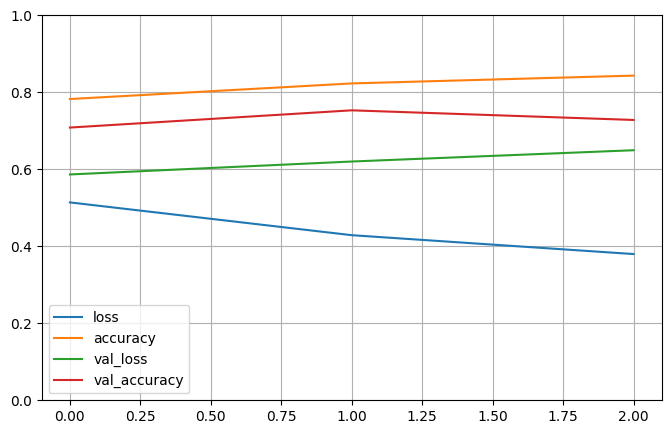

Train sizes (6955, 3997) (6955, 1)
Train set ones/size 5424 / 6955
Compute valiation accuracy
2023-02-04 13:02:35.438147
Valid sizes (1519, 3997) (1519, 1)
Valid set ones/size 1160 / 1519
Range of scores: 0.020565793 to 0.995346
Score threshold 0.5
Prediction set ones/size 1287 / 1519


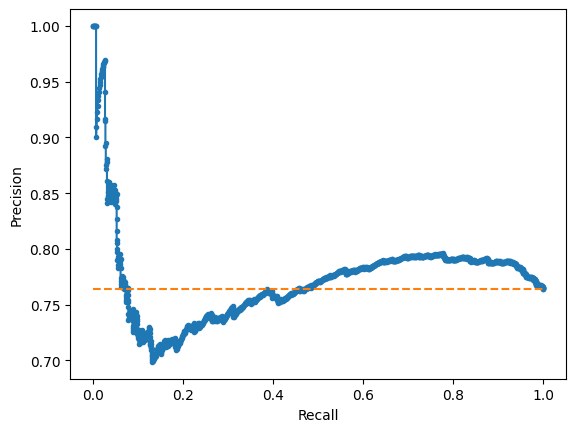

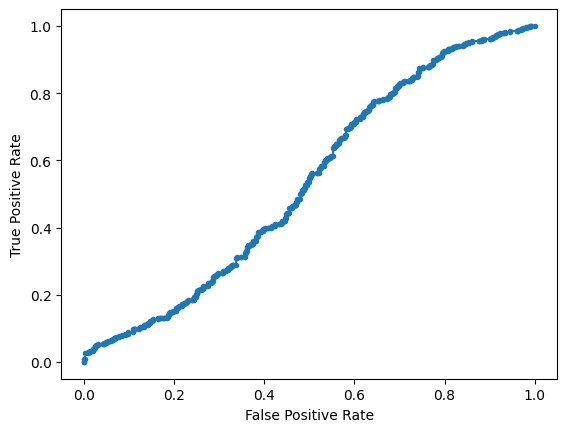

Accuracy: 72.81% Precision: 79.02% Recall: 87.67%
F1: 83.12% AUPRC: 77.32% AUROC: 53.42%
2023-02-04 13:02:37.026999
Fold 4
Training example
[211  74  38 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-02-04 13:02:41.053132
Epoch 1/3
191/191 [==============================] - 26s 129ms/step - loss: 0.5591 - accuracy: 0.7581 - val_loss: 0.4726 - val_accuracy: 0.8035
Epoch 2/3
191/191 [==============================] - 25s 129ms/step - loss: 0.5140 - accuracy: 0.7716 - val_loss: 0.5216 - val_accuracy: 0.7943
Epoch 3/3
191/191 [==============================] - 25s 129ms/step - loss: 0.4866 - accuracy: 0.7900 - val_loss: 0.4982 - val_accuracy: 0.8035
2023-02-04 13:03:55.918435


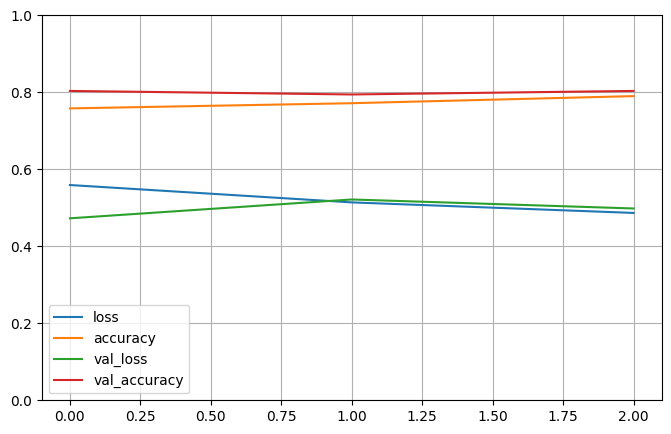

Train sizes (6082, 3997) (6082, 1)
Train set ones/size 4661 / 6082
Compute valiation accuracy
2023-02-04 13:03:56.132011
Valid sizes (2392, 3997) (2392, 1)
Valid set ones/size 1923 / 2392
Range of scores: 0.4542419 to 0.9909837
Score threshold 0.5
Prediction set ones/size 2391 / 2392


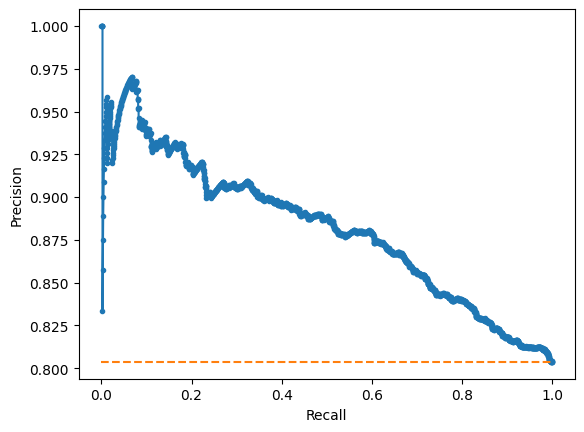

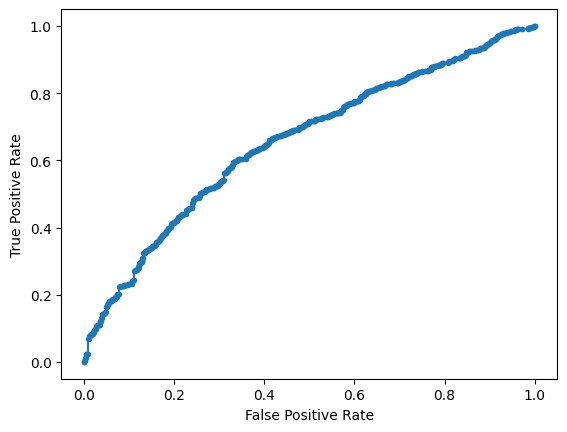

Accuracy: 80.35% Precision: 80.38% Recall: 99.95%
F1: 89.11% AUPRC: 88.14% AUROC: 65.54%
2023-02-04 13:03:58.259617
Fold 5
Training example
[211  74  38 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-02-04 13:04:02.325219
Epoch 1/3
226/226 [==============================] - 29s 125ms/step - loss: 0.5468 - accuracy: 0.7623 - val_loss: 0.4490 - val_accuracy: 0.8433
Epoch 2/3
226/226 [==============================] - 29s 128ms/step - loss: 0.4796 - accuracy: 0.7905 - val_loss: 0.4683 - val_accuracy: 0.8369
Epoch 3/3
226/226 [==============================] - 34s 152ms/step - loss: 0.4069 - accuracy: 0.8290 - val_loss: 0.4417 - val_accuracy: 0.8401
2023-02-04 13:05:34.969531


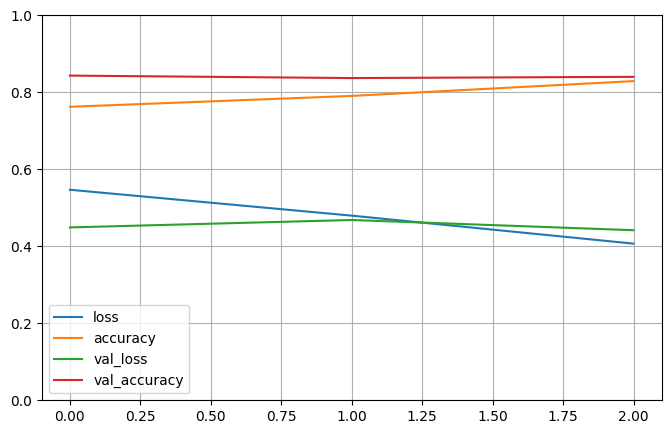

Train sizes (7223, 3997) (7223, 1)
Train set ones/size 5527 / 7223
Compute valiation accuracy
2023-02-04 13:05:35.165168
Valid sizes (1251, 3997) (1251, 1)
Valid set ones/size 1057 / 1251
Range of scores: 0.12657593 to 0.99625653
Score threshold 0.5
Prediction set ones/size 1197 / 1251


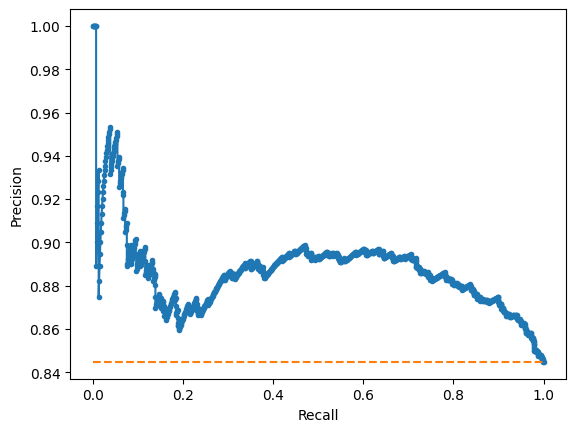

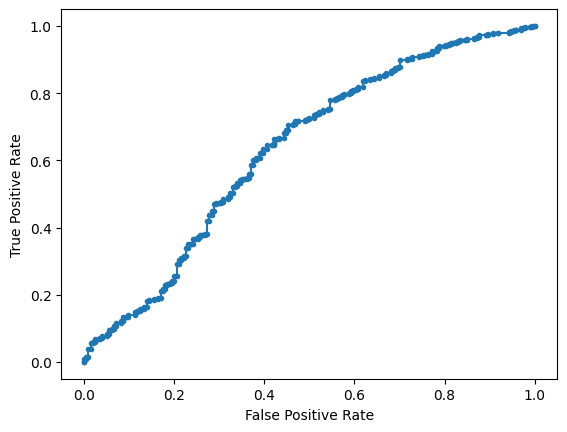

Accuracy: 84.01% Precision: 85.80% Recall: 97.16%
F1: 91.13% AUPRC: 88.69% AUROC: 63.36%
2023-02-04 13:05:36.546602

Cross validation 5 folds 3 epochs
 accuracy mean 76.86% +/- 4.66
 precision mean 79.54% +/- 3.63
 recall mean 94.16% +/- 4.35
 F1 mean 86.19% +/- 3.44
 AUPRC mean 83.49% +/- 4.32
 AUROC mean 61.05% +/- 4.78
2023-02-04 13:05:37.997667


In [12]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
cvdo = None
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc)))
print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc)))
print(datetime.now())